# Examine a sequence

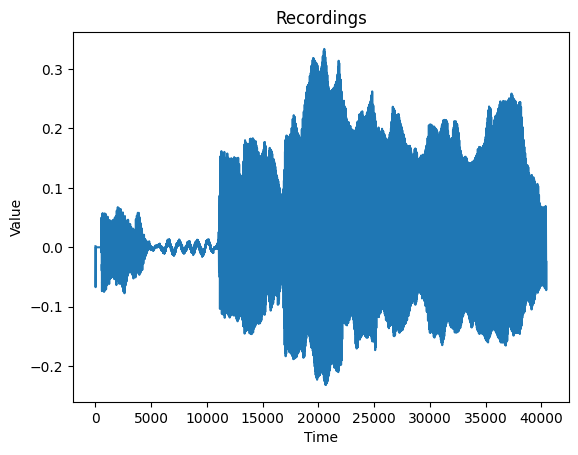

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
data = pd.read_csv('recordings.csv')

# Plot the data
plt.plot(data)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Recordings')

# Show the plot
plt.show()


# Generate commands

## Use Bash

### Run

```sh
cd src
javac -d ../bin $(find . -name "*.java")
cd ..
java -cp ./bin com.AcousticNFC.Host
```

### Compress

```sh
cd src
javac -d ../bin $(find . -name "*.java")
cd ..
jar cvfm AcousticNFCHost.jar manifest.txt -C bin/ .
```

# Project 1

## Part 2 sound check

In [7]:
# play 1000hz and 10000hz together

from pydub import AudioSegment
from pydub.playback import play
import numpy as np

# Function to generate a tone of particular frequency
def generate_tone(frequency, duration_ms=1000, volume=-30.0):
    # Set sample_rate to the best your mic can offer
    sample_rate = 44100  

    # Generate array
    samples = (np.sin(2*np.pi*np.arange(sample_rate*duration_ms/1000)*frequency/sample_rate))
    # adjust volume
    samples = (samples * (10**(volume/20))*32768).astype(np.int16)

    # Convert to an audio segment
    audio_segment = AudioSegment(
        # raw 16-bit audio
        samples.tobytes(), 
        # 2 bytes (16 bit) sample width
        sample_width=2,
        # 44.1 kHz frame rate
        frame_rate=sample_rate,
        # single channel
        channels=1
    )

    # Decrease the volume 
    audio_segment = audio_segment

    return audio_segment

# Generate the two tones
tone_1000hz = generate_tone(1000)
tone_10000hz = generate_tone(10000)

# Overlay the two tones
combined_tones = tone_1000hz.overlay(tone_10000hz)

# Play combined tone
play(combined_tones)
